<a href="https://colab.research.google.com/github/hahaSam351/Study/blob/main/03_Bike_Sharing_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing Demand

- https://www.kaggle.com/c/bike-sharing-demand/overview
- https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile#About-Dataset

# 1) Load and check data

## 1-1) Library

In [ ]:
# 1.기본
# data handling
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', 100)

# visualization
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우 폰트
# plt.rcParams['font.family'] = 'AppleGothic'   # 애플 폰트
plt.rcParams['font.size'] = 14   # 폰트 크기
plt.rcParams['figure.figsize'] = 8, 8   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep', font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')

# etc...
import time
import scipy.stats as stats


# 2. 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')


# 3. 데이터 전처리
# 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 => 원본 데이터 그대로 유지
from sklearn.preprocessing import StandardScaler # SVM(RBF), 로지스틱회귀, 선형회귀, 인공신경망의 경우 표준화(standardization)
from sklearn.preprocessing import MinMaxScaler # 군집 분석의 경우 정규화(normalization)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures # 다항 회귀
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
import missingno as msno
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold


# 5. 분류 모델 구축
# reg (Regression)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Voting
from sklearn.ensemble import VotingRegressor
# Bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
# Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
# Stacking
from sklearn.ensemble import StackingRegressor

# dp (deeplearning)
from sklearn.neural_network import MLPClassifier, MLPRegressor


# 6. 모델 검정
from sklearn.model_selection import cross_val_score # 검증 지표를 하나만 사용할 경우
from sklearn.model_selection import cross_validate # 검증 지표를 다수를 설정할 경우
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 7. 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1-2) Load and Data Check

In [ ]:
train = pd.read_csv(r'/content/drive/MyDrive/DataAnalysis/0. Datasets/Bike Sharing Demand/bike_train.csv')
test = pd.read_csv(r'/content/drive/MyDrive/DataAnalysis/0. Datasets/Bike Sharing Demand/bike_test.csv')

In [ ]:
sub_test = test.datetime

In [ ]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [ ]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('dataset.shape :', dataset.shape)

train.shape : (10886, 12)
test.shape : (6493, 9)
dataset.shape : (17379, 12)


In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [ ]:
dataset.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# dataset.describe(include=['object'])

In [ ]:
dataset.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
dtype: int64

# 2) EDA

## 2-1) Target

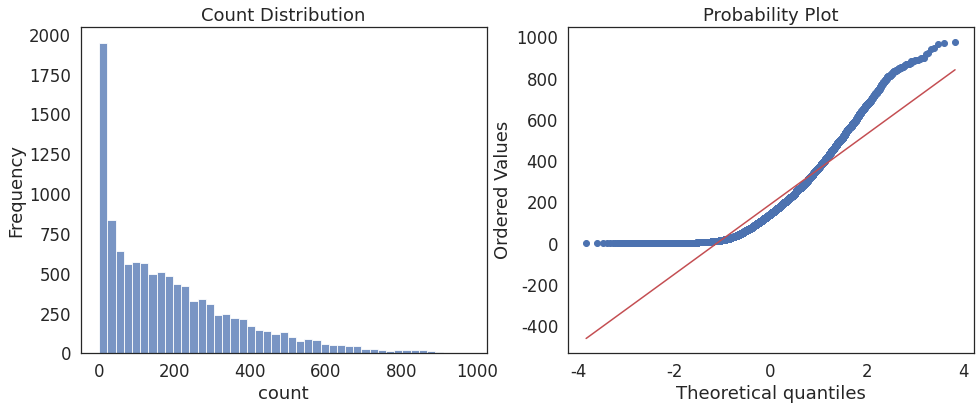

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(16,6))

sns.histplot(train['count'], ax=ax[0])
ax[0].set_title('Count Distribution')
ax[0].set_ylabel('Frequency')

qq = stats.probplot(np.array(train['count']), plot=ax[1])
plt.show()

In [ ]:
dataset['log_count'] = dataset['count'].apply(lambda x : np.log1p(x))

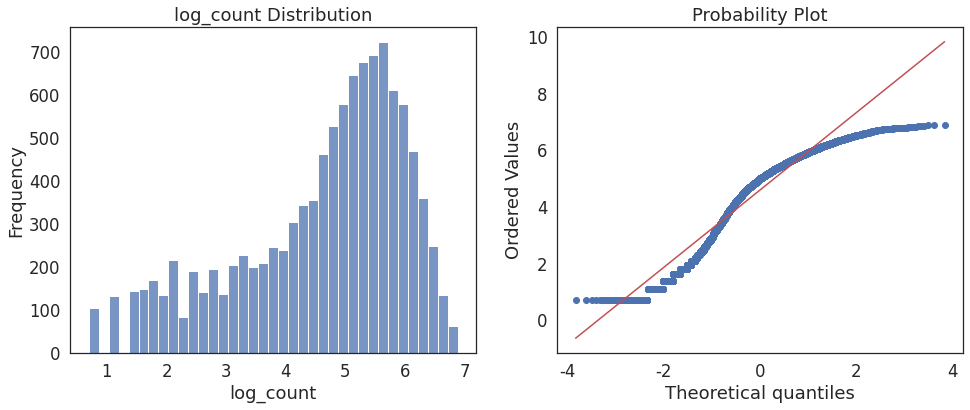

In [ ]:
train['log_count'] = np.log1p(train['count'])

f, ax = plt.subplots(1, 2, figsize=(16,6))

sns.histplot(train['log_count'], ax=ax[0])
ax[0].set_title('log_count Distribution')
ax[0].set_ylabel('Frequency')

qq = stats.probplot(np.array(train['log_count']), plot=ax[1])
plt.show()

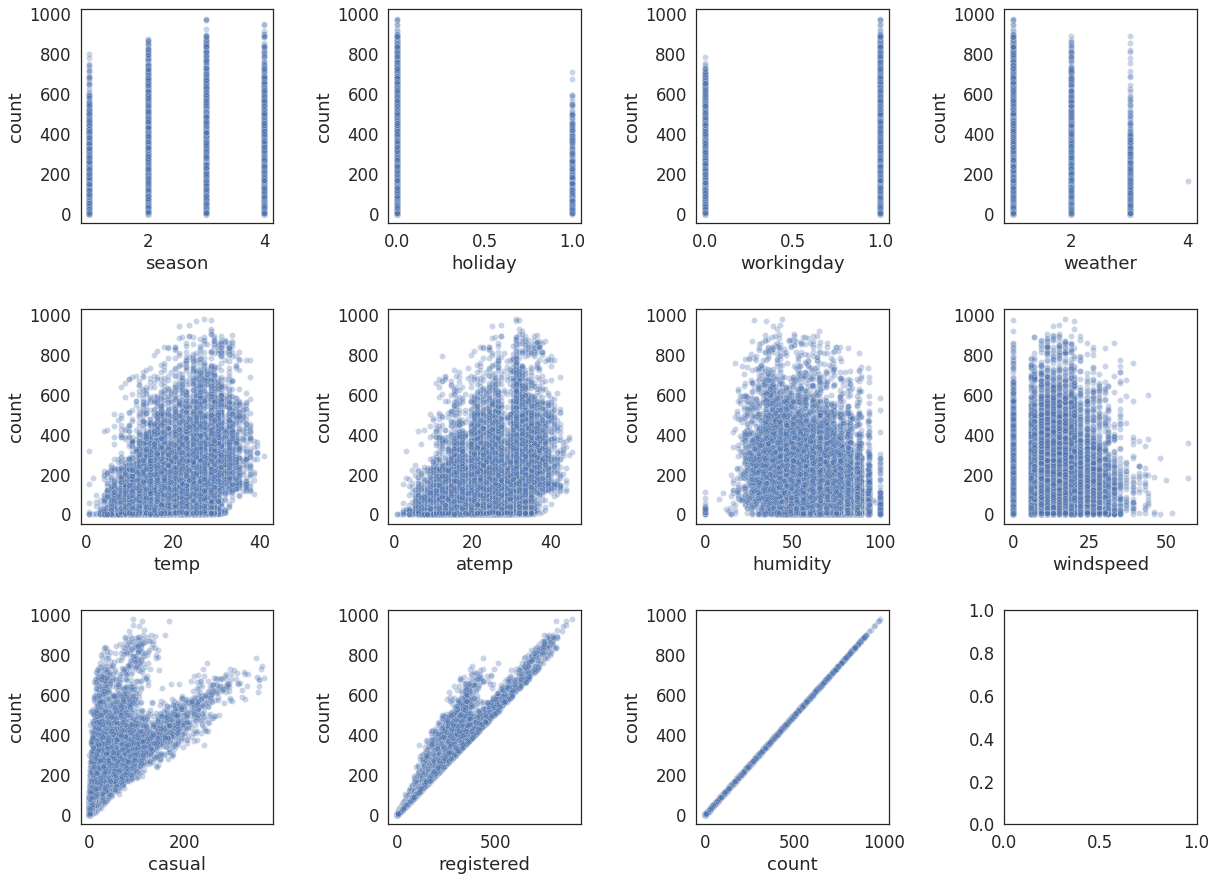

In [ ]:
f, ax = plt.subplots(3,4, figsize=(20,15))
f.subplots_adjust(hspace=0.4, wspace=0.6)
for i, feature in enumerate(train.columns[1:-1]) :
  row = int(i/4)
  col = i%4
  sns.scatterplot(x=feature, y='count', data=train, ax=ax[row][col], alpha=0.3)

## 2-2) Features

### casual, registered

In [ ]:
dataset.drop(columns=['casual', 'registered'], axis=1, inplace=True)

### datetime

In [ ]:
dataset['datetime'] = dataset.datetime.apply(pd.to_datetime)

dataset['year'] = dataset.datetime.apply(lambda x : x.year)
dataset['month'] = dataset.datetime.apply(lambda x : x.month)
dataset['day'] = dataset.datetime.apply(lambda x : x.day)
dataset['weekday'] = dataset.datetime.apply(lambda x : x.weekday())
dataset['hour'] = dataset.datetime.apply(lambda x : x.hour)

dataset.drop(columns=['datetime'], axis=1, inplace=True)

In [ ]:
train = dataset.iloc[:train_len,:]

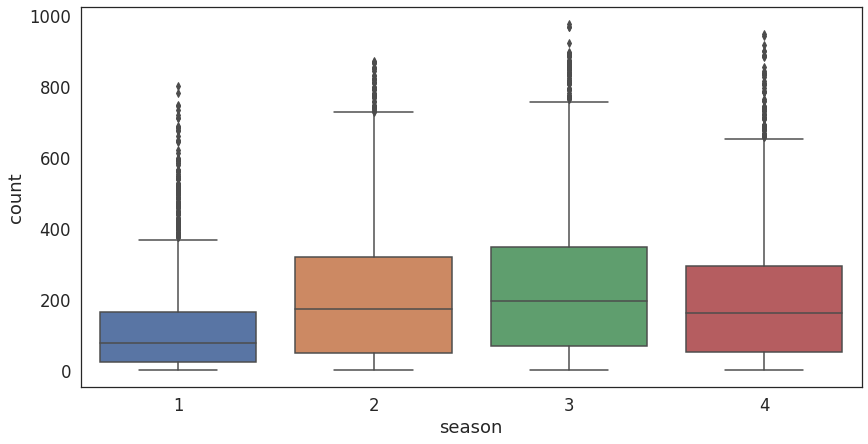

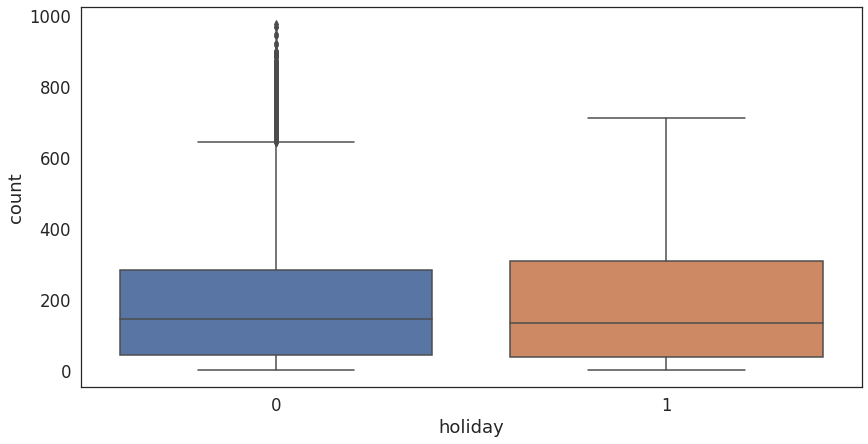

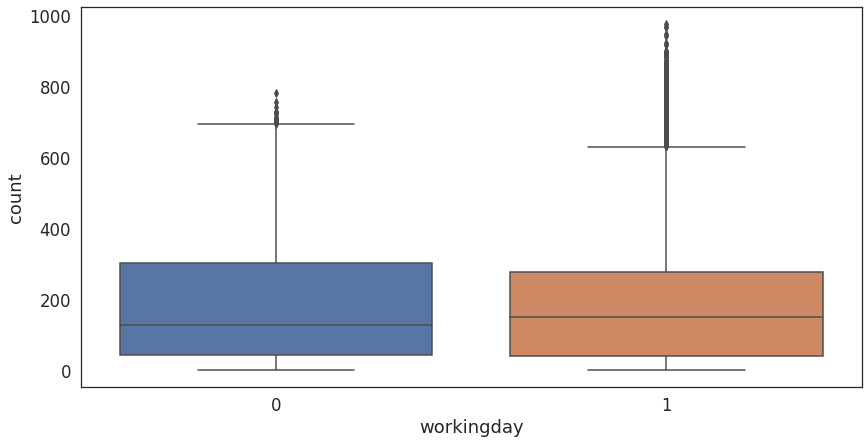

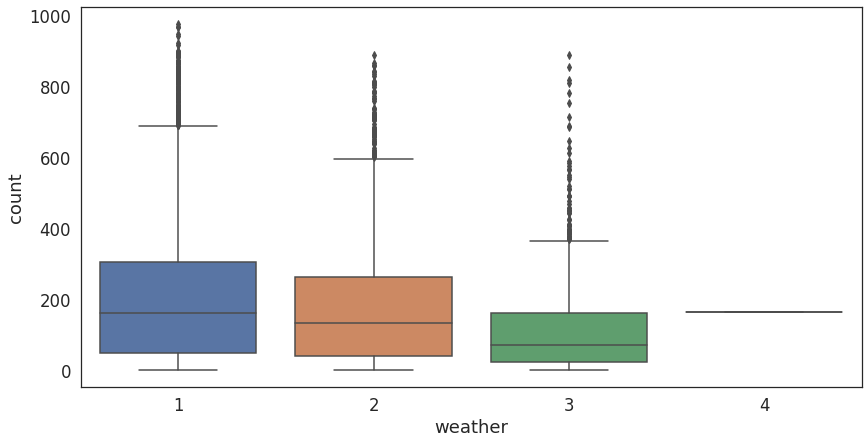

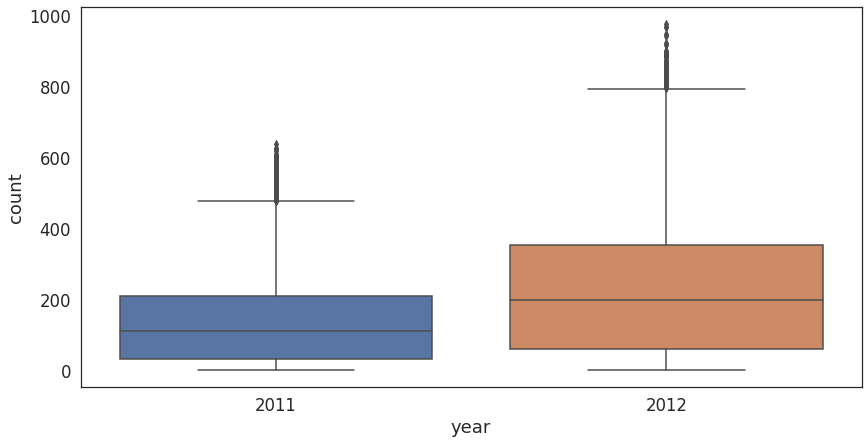

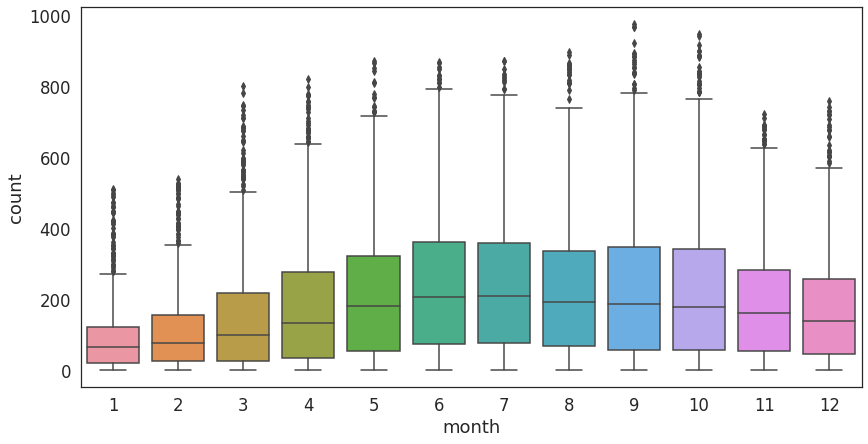

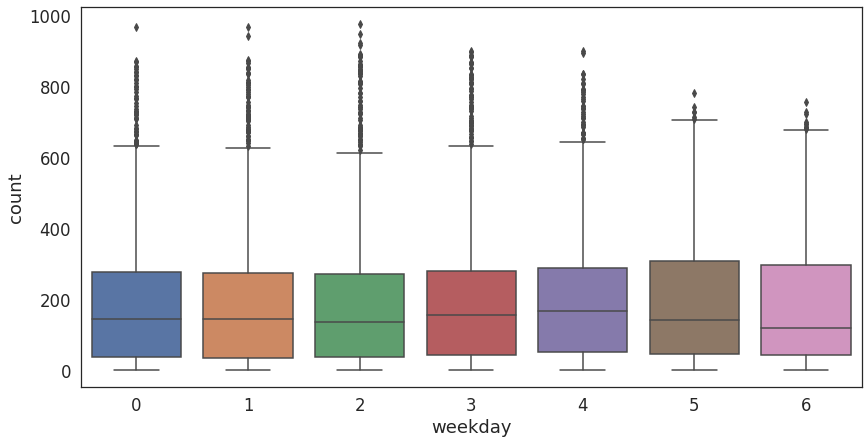

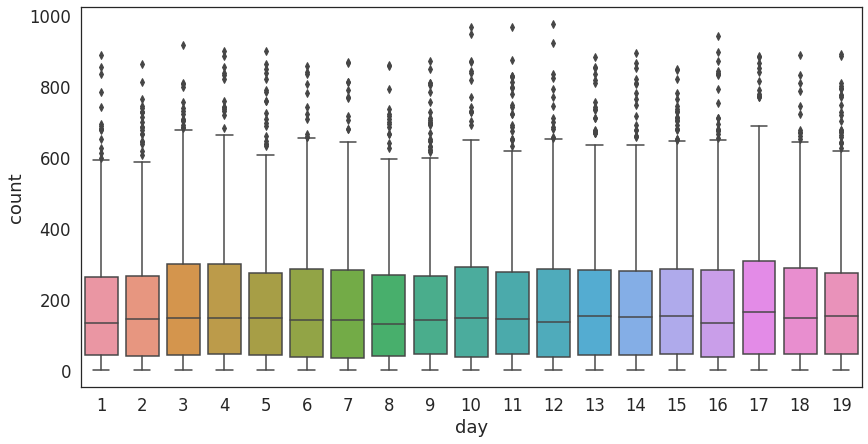

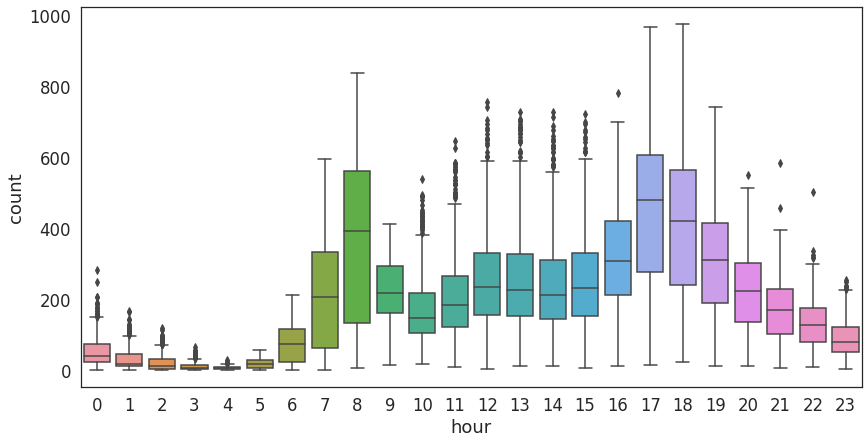

In [ ]:
lst = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'weekday', 'day', 'hour']

for i, feature in enumerate(lst) :
  row = int(i/4)
  col = i%4
  plt.figure(figsize=(14, 7))
  sns.boxplot(x=feature, y='count', data=train)
  plt.show()

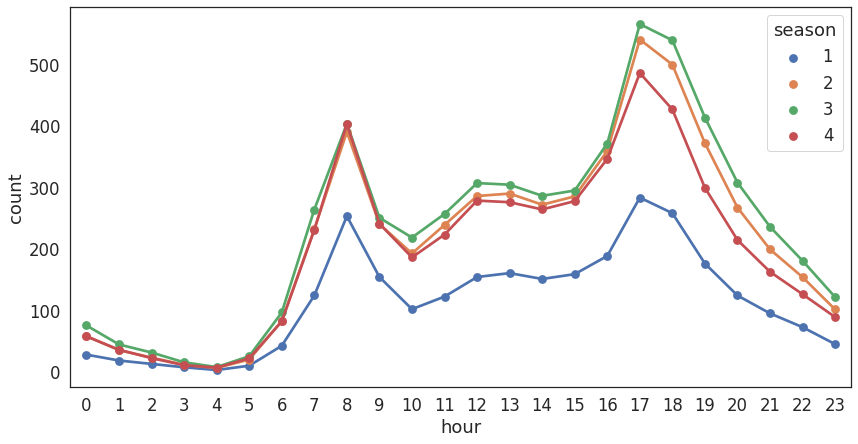

In [ ]:
df_vis = pd.DataFrame(train.groupby(['hour','season']).mean()['count']).reset_index()

plt.figure(figsize=(14,7))
sns.pointplot(x=df_vis['hour'], y=df_vis['count'], hue=df_vis['season'], data=df_vis)
plt.show()

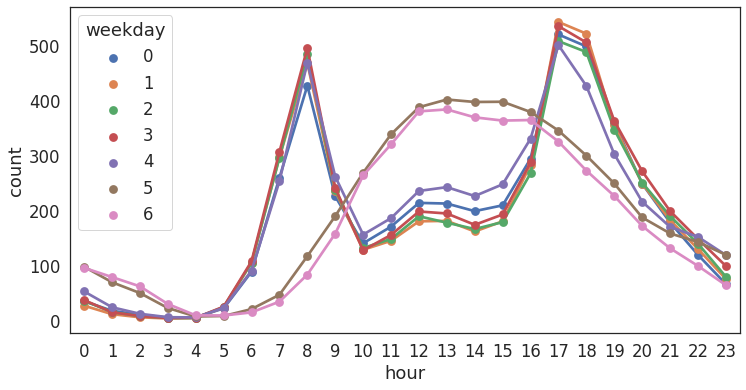

In [ ]:
df_vis = pd.DataFrame(train.groupby(['hour','weekday']).mean()['count']).reset_index()

plt.figure(figsize=(12,6))
sns.pointplot(x=df_vis['hour'], y=df_vis['count'], hue=df_vis['weekday'], data=df_vis)
plt.show()

## 2-3) Correlation

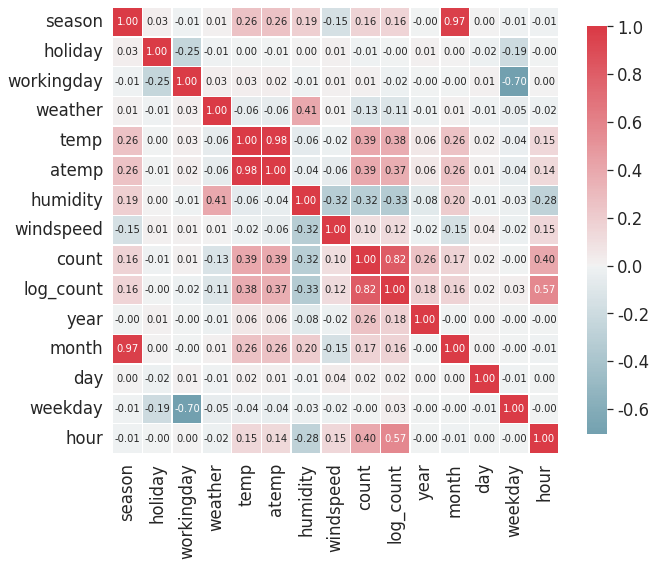

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), cmap=cmap, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
plt.show()

# 3) Feature Engineering

## 3-1) Encoding (categorical)

In [ ]:
dataset = pd.get_dummies(dataset, columns=['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour'])

# 4) Modeling

## 4-0) Data split

In [ ]:
dataset.head()

,temp,atemp,humidity,windspeed,count,log_count,weekday,season_1,season_2,season_3,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,14.395,81,0.0,16.0,2.833213,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0,40.0,3.713572,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0,32.0,3.496508,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0,13.0,2.639057,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0,1.0,0.693147,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = dataset.iloc[:train_len,:]
test = dataset.iloc[train_len:,:]
train.drop('count', axis=1, inplace=True)
test.drop(columns=['count','log_count'], axis=1, inplace=True)

In [ ]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('dataset.shape :', dataset.shape)

train.shape : (10886, 87)
test.shape : (6493, 86)
dataset.shape : (17379, 88)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['log_count'], axis=1), train['log_count'], test_size=0.3, random_state=0)

## 4-1) Basic Algorithms

In [ ]:
def rmsle(y, pred) :
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

def rmse(y, pred) :
  return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred) :
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE : {0:.3f}\nRMSE : {1:.3f}\nMAE : {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

  # 트리 모델 X
  try: 
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_sort = coef.sort_values(ascending=False)[:20]
    plt.figure(figsize=(8,8))
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    plt.show()
  except :
    pass

In [ ]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False) :
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  
  if is_expm1 :
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  
  print('<<', model.__class__.__name__, '>>')
  evaluate_regr(y_test, pred)

<< LinearRegression >>
RMSLE : 0.588
RMSE : 97.801
MAE : 63.267


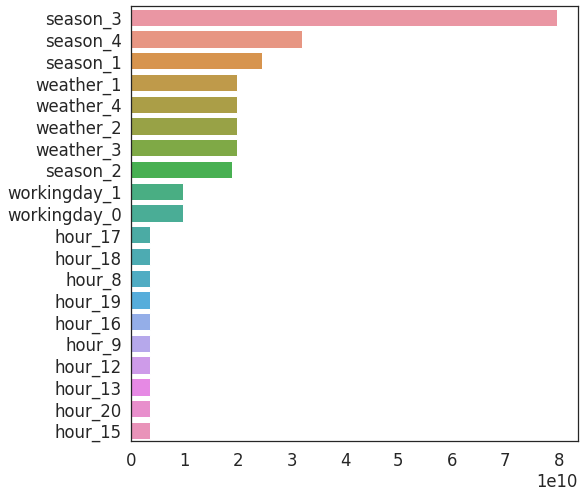

<< Ridge >>
RMSLE : 0.588
RMSE : 97.856
MAE : 63.290


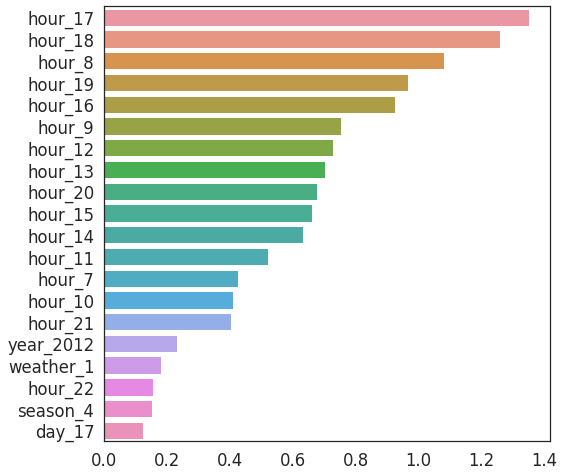

<< Lasso >>
RMSLE : 1.240
RMSE : 177.722
MAE : 121.342


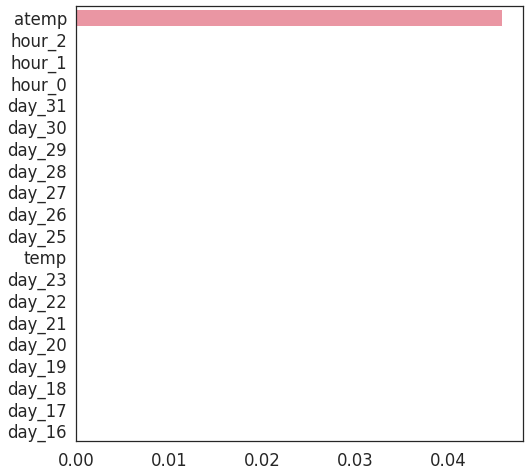

<< RandomForestRegressor >>
RMSLE : 0.339
RMSE : 48.329
MAE : 29.163
<< GradientBoostingRegressor >>
RMSLE : 0.334
RMSE : 57.622
MAE : 34.267
<< XGBRegressor >>
[09:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE : 0.331
RMSE : 55.833
MAE : 33.349
<< LGBMRegressor >>
RMSLE : 0.299
RMSE : 44.325
MAE : 26.501


,RMSLE,RMSE,MAE
LinearRegression,0.587938,97.801453,63.266997
Ridge,0.587835,97.855704,63.290446
Lasso,1.239868,177.721578,121.342409
RandomForestRegressor,0.339147,48.328742,29.163026
GradientBoostingRegressor,0.333733,57.621913,34.266560
XGBRegressor,0.330616,55.833153,33.348998
LGBMRegressor,0.298546,44.325043,26.501440


In [ ]:
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

models = [lr_reg, ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]
models_name = [model.__class__.__name__ for model in models]

RMSLE = []
RMSE = []
MAE = []

for model in models :

  print('<<', model.__class__.__name__, '>>')

  model.fit(X_train.values, y_train.values)
  pred = model.predict(X_val.values)

  # # np.lop1p() 해제
  y_val_count = np.expm1(y_val.values)
  pred = np.expm1(pred)

  evaluate_regr(y_val_count, pred)
  
  RMSLE.append(rmsle(y_val_count, pred))
  RMSE.append(rmse(y_val_count, pred))
  MAE.append(mean_absolute_error(y_val_count, pred))

  print('='*80)

models_dataframe = pd.DataFrame({'RMSLE':RMSLE, 'RMSE':RMSE, 'MAE':MAE}, index=models_name)
models_dataframe

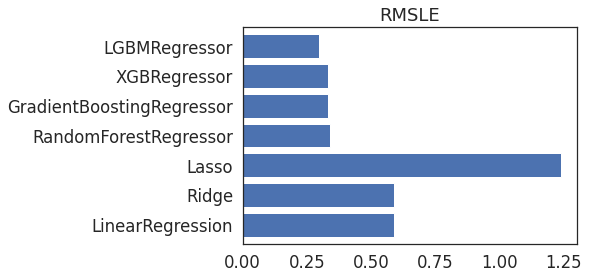

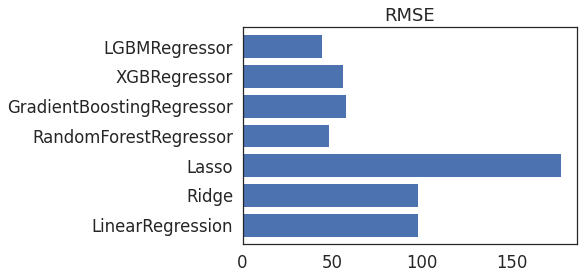

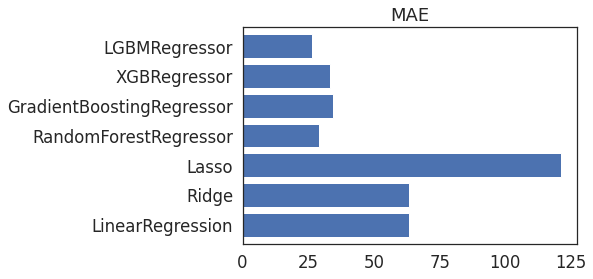

In [ ]:
for i in models_dataframe.columns :
  models_dataframe[i].plot.barh(width=0.8)
  plt.title(i)
  plt.show()

# 5) Prediction on Test Set & Submission 

## 5-1) Prediction

In [ ]:
lgbm_reg = LGBMRegressor(n_estimators=500)
lgbm_reg.fit(train.drop(['log_count'], axis=1), train['log_count'])
pred = lgbm_reg.predict(test)
pred = np.expm1(pred)   # np.lop1p() 해제

## 5-2) Submission

In [ ]:
sub_test

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

In [ ]:
sub_pred = pd.Series(pred, name="count")
sub_pred

0        12.180687
1         4.004269
2         2.941633
3         3.243403
4         1.593799
           ...    
6488    226.510460
6489    154.158063
6490    110.046073
6491     79.786268
6492     40.250001
Name: count, Length: 6493, dtype: float64

In [ ]:
results = pd.concat([sub_test, sub_pred], axis=1)
results

,datetime,count
0,2011-01-20 00:00:00,12.180687
1,2011-01-20 01:00:00,4.004269
2,2011-01-20 02:00:00,2.941633
3,2011-01-20 03:00:00,3.243403
4,2011-01-20 04:00:00,1.593799
...,...,...
6488,2012-12-31 19:00:00,226.510460
6489,2012-12-31 20:00:00,154.158063
6490,2012-12-31 21:00:00,110.046073
6491,2012-12-31 22:00:00,79.786268


In [ ]:
results.to_csv("bike_2.csv", index=False)